# Dueling DQN

## Installation 

In [ ]:
!pip install gymnasium
!pip install -q swig
!pip install gymnasium[box2d]

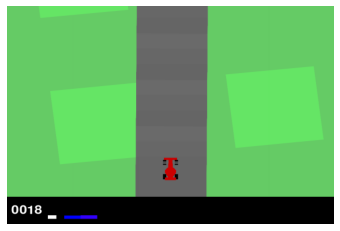

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
env.reset()
for i in range(50):
  env.step(3)

plt.imshow(env.render())
plt.axis("off");

## Definitons

In [6]:
import random
import torch
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

In [7]:
from collections import deque

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [9]:
from gymnasium.wrappers import RecordVideo

def create_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array", continuous=False)
  environment = RecordVideo(environment, video_folder=f"./{name}_recored_episodes", episode_trigger=lambda x: x % 5 == 0)

  return environment

In [10]:
from torch.nn import ReLU, Conv2d, ReLU, Module, Flatten, AvgPool2d, Sequential, Linear
import torch.autograd as autograd

class ConvDuelingDQN(Module):

    def __init__(self, hidden_size, input_dim, output_dim):
        super(ConvDuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.start_time = time.time()

        self.conv = Sequential(
            Conv2d(3, 16, kernel_size=3, stride=3),
            ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=3),
            ReLU(),
            Flatten()
        )

        self.fc_input_dim = 3200

        self.value_stream = Sequential(
            Linear(self.fc_input_dim, hidden_size),
            ReLU(),
            Linear(hidden_size, 1)
        )

        self.advantage_stream = Sequential(
            Linear(self.fc_input_dim, hidden_size),
            ReLU(),
            Linear(hidden_size, self.output_dim)
        )

    def forward(self, state):
        features = self.conv(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals

In [22]:
import time
from torch.optim import AdamW
from copy import deepcopy
from torch.nn.functional import smooth_l1_loss

class DeepQLearning():

  def __init__(self, env_name, net=None, policy=epsilon_greedy, capacity=20_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=600, samples_per_epoch=1024, sync_rate=25, play_episode_rate=5):
      self.env_name = env_name
      self.env = create_gym_environment(env_name)

      obs_size = self.env.observation_space.shape[0]
      n_actions = self.env.action_space.n

      self.q_net = net if net else ConvDuelingDQN(hidden_size, obs_size, n_actions)

      self.optim = optim(self.q_net.parameters(), lr)
      self.target_q_net = deepcopy(self.q_net)

      self.policy = policy
      self.buffer = ReplayBuffer(capacity=capacity)
      self.loss_fn = loss_fn

      self.gamma = gamma
      self.batch_size = batch_size
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_last_episode = eps_last_episode
      self.sync_rate = sync_rate
      self.samples_per_epoch = samples_per_epoch
      self.lr = lr
      self.play_episode_rate = play_episode_rate

      self.current_epoch = 1
      self.log = []
      self.returns = []
      self.episode_lengths = []
      self.start_time = time.time()

      while len(self.buffer) < self.samples_per_epoch:
        self.play_episode(epsilon=1.0)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
      state = self.env.reset()[0]
      done = False
      rewards = 0
      epsiode_length = 0

      while not done:
        state_v = torch.permute(torch.tensor(state), (2, 0, 1))/255.0
        if policy:
          action = policy(state_v.unsqueeze(0), self.env, self.q_net, epsilon=epsilon)
        else:
          action = self.env.action_space.sample()


        next_state, reward, done1, done2, info = self.env.step(action)
        done = done1 or done2

        rewards += reward
        epsiode_length += 1

        next_state_v = torch.permute(torch.tensor(next_state), (2, 0, 1))/255.0
        action_v = torch.tensor(action)
        reward_v = torch.tensor(reward)
        done_v = torch.tensor(done)
        exp = (state_v, action_v, reward_v, done_v, next_state_v)

        self.buffer.append(exp)
        state = next_state
      return rewards, epsiode_length


  def fit(self, n_epoch):
      for epoch in range(n_epoch):
        loss_total = 0
        for _ in range(self.samples_per_epoch//self.batch_size):

          loss = self.training_step()
          loss_total += loss

        last_return, episode_length  = self.training_epoch_end()

        if last_return is not None:
          self.returns.append(last_return)
          self.episode_lengths.append(episode_length)
          self.log.append([self.current_epoch, last_return, loss_total.item()])

        if self.current_epoch % 25 == 0:
          print(f"Epoch: {self.current_epoch}, mean return: {np.mean(self.returns[-10:]):.2f}, " \
           f"mean episode length: {np.mean(self.episode_lengths[-10:])}, loss: {loss_total:.2f}")


  def training_step(self):
      batch_T = self.buffer.sample(self.batch_size)
      batch = list(map(torch.stack, zip(*batch_T)))

      states, actions, rewards, dones, next_states = batch
      actions = actions.unsqueeze(1)
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)
      state_action_values = self.q_net(states).gather(1, actions)

      next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
      next_action_values[dones] = 0.0

      expected_state_action_values = rewards + self.gamma * next_action_values
      loss = self.loss_fn(state_action_values, expected_state_action_values)

      self.optim.zero_grad()
      loss.backward()
      self.optim.step()
      return loss


  def training_epoch_end(self):
      epsilon = max(self.eps_end, self.eps_start - self.current_epoch / self.eps_last_episode)

      if self.current_epoch % self.play_episode_rate == 0:
        last_return, episode_length = self.play_episode(policy=self.policy, epsilon=epsilon)
      else:
        last_return = None
        episode_length = None

      if self.current_epoch % self.sync_rate == 0:
        self.target_q_net.load_state_dict(self.q_net.state_dict())
      self.current_epoch += 1
      return last_return, episode_length

## Training

In [45]:
import shutil

try:
    shutil.rmtree("CarRacing-v2_recored_episodes", ignore_errors=True)
except:
    pass
# q_net = torch.load("CarRacing_qnet")

In [ ]:
algo = DeepQLearning("CarRacing-v2", q_net, eps_last_episode=1200, eps_start=0.8, eps_end=0.10, samples_per_epoch=512, batch_size=128)
algo.fit(2000)

In [24]:
torch.save(algo.q_net, "CarRacing_qnet")

## Testing

In [25]:
q_net = torch.load("CarRacing_qnet")

In [28]:
from gymnasium.wrappers import RecordVideo

def create_test_gym_environment(name):
  environment = gym.make(name, render_mode="rgb_array", continuous=False)
  environment = RecordVideo(environment, video_folder=f"./test_{name}", episode_trigger=lambda x: x % 1 == 0)

  return environment

In [42]:
  def play_episode(test_env, q_net):
      state = test_env.reset()[0]
      done = False

      while not done:
        state_v = torch.permute(torch.tensor(state), (2, 0, 1))/255.0
        action = epsilon_greedy(state_v.unsqueeze(0), test_env, q_net, epsilon=0.0)

        next_state, reward, done1, done2, info = test_env.step(action)
        done = done1 or done2
        
        state = next_state

In [ ]:
test_env = create_test_gym_environment("CarRacing-v2")
for i in range(10):
    play_episode(test_env, q_net)